In [1]:
import numpy as np
import poke.poke_core as pol
import poke.plotting as plt
from astropy.io import fits
import astropy.units as u
import poppy


In [2]:
pth = 'Subaru_M1-M3_750nm.fits'

jones_pupil = fits.open(pth)[0].data

# Reclaim the complex numbers from the fits file ;-;
J11 = jones_pupil[:,:,0,0,0] + 1j*jones_pupil[:,:,0,0,1] 
J12 = jones_pupil[:,:,0,1,0] + 1j*jones_pupil[:,:,0,1,1]

J21 = jones_pupil[:,:,1,0,0] + 1j*jones_pupil[:,:,1,0,1] 
J22 = jones_pupil[:,:,1,1,0] + 1j*jones_pupil[:,:,1,1,1] 

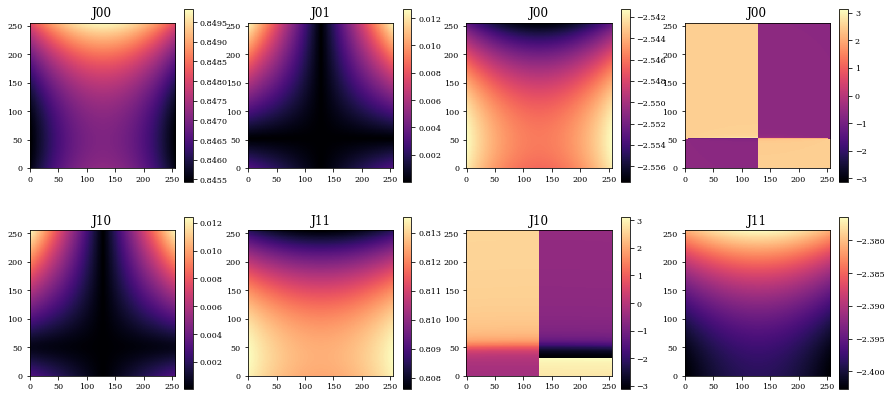

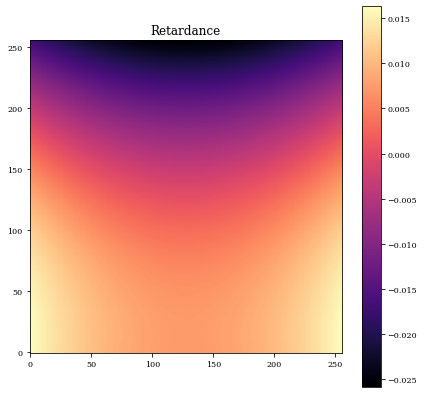

In [10]:
plt.PlotJonesArray(J11,J12,J21,J22)

ret = np.angle(J11)-np.angle(J22)
ret -= np.mean(ret)

plot.figure(figsize=[7,7])
plot.title('Retardance')
plot.imshow(ret)
plot.colorbar()
plot.show()

In [22]:
# Define some input linear polarization state
E = np.array([1,0,0])
# E /= np.linalg.norm(E) # Make sure that we don't violate conservation of energy

wl = 750e-9*u.m 
npix = 256*u.pix
diam = 8.2*u.m 
pixelscale = diam/npix
os = 8

# Make Jones Array Optical Elements
def MakeArrayOpticalElement(jxx,wl,pixscal):

    trans = np.abs(jxx)
    opd = np.angle(jxx) * wl/(2*np.pi)

    optic = poppy.ArrayOpticalElement(transmission=trans,opd=opd,pixelscale=pixscal)

    return optic 

def MakeMeanOpticalElement(jxx,wl,pixscal):

    trans = np.abs(jxx)
    trans_mean = np.mean(trans)
    trans = trans*0 + trans_mean

    opd = np.angle(jxx) * wl/(2*np.pi)
    opd_mean = np.mean(opd)
    opd = opd*0 # no aberration allowed

    optic = poppy.ArrayOpticalElement(transmission=trans,opd=opd,pixelscale=pixscal)

    return optic 

j11 = MakeArrayOpticalElement(J11,wl,pixelscale)
j12 = MakeArrayOpticalElement(J12,wl,pixelscale)
j21 = MakeArrayOpticalElement(J21,wl,pixelscale)
j22 = MakeArrayOpticalElement(J22,wl,pixelscale)

j11_mean = MakeMeanOpticalElement(J11,wl,pixelscale)
j12_mean = MakeMeanOpticalElement(J12,wl,pixelscale)
j21_mean = MakeMeanOpticalElement(J21,wl,pixelscale)
j22_mean = MakeMeanOpticalElement(J22,wl,pixelscale)

def PropagateToFocus(jxx):

    wf = poppy.FresnelWavefront(beam_radius=4.1*u.m,oversample=os,wavelength=750e-9*u.m)
    subaru_efl = 110.629*u.m
    osys = poppy.FresnelOpticalSystem()
    osys.add_optic(poppy.CircularAperture(radius=4.1*u.m))
    osys.add_optic(jxx)
    osys.add_optic(poppy.QuadraticLens(subaru_efl))
    osys.add_optic(poppy.ScalarTransmission(),distance=subaru_efl)
    wfout = osys.propagate(wf)

    return wfout

psf_j11 = PropagateToFocus(j11)
psf_j12 = PropagateToFocus(j12)
psf_j21 = PropagateToFocus(j21)
psf_j22 = PropagateToFocus(j22)
psf_ref = PropagateToFocus(j11_mean)

After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8192); will zero-pad the rescaled array.
After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8192); will zero-pad the rescaled array.
After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8192); will zero-pad the rescaled array.
After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8192); will zero-pad the rescaled array.
After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8192); will zero-pad the rescaled array.


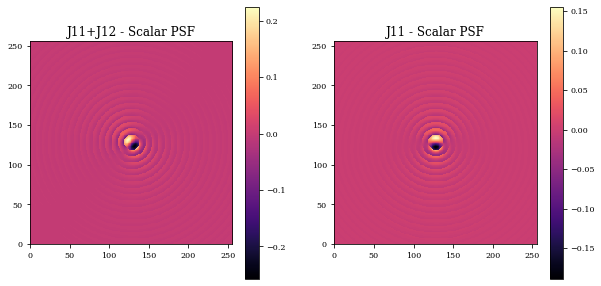

In [27]:
import matplotlib.pyplot as plot
from matplotlib.colors import LogNorm

def CropCenter(array,cut):

    dim = array.shape[0]
    array_out = array[int(dim/2 - cut):int(dim/2 + cut),int(dim/2 - cut):int(dim/2 + cut)]

    return array_out

j11_out = CropCenter(psf_j11.wavefront,128)
j12_out = CropCenter(psf_j12.wavefront,128)
ref_out = np.abs(CropCenter(psf_ref.wavefront,128))

pol_out = np.abs(j11_out + j12_out)

just_j11 = np.abs(CropCenter(psf_j11.wavefront,128))

plot.figure(figsize=[10,5])
plot.subplot(121)
plot.title('J11+J12 - Scalar PSF')
plot.imshow(pol_out-ref_out)
plot.colorbar()

plot.subplot(122)
plot.title('J11 - Scalar PSF')
plot.imshow(just_j11-ref_out)
plot.colorbar()
plot.show()

(8192, 8192)